<a href="https://colab.research.google.com/github/veshitala/Deep_learning_experiments/blob/master/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2019-05-24 05:44:46--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 2a00:1450:4013:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  37.9MB/s    in 2.2s    

2019-05-24 05:44:48 (37.9 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Instructions for updating:
Colocations handled automatically by placer.
last layer output shape:  (None, 7, 7, 768)


In [0]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

In [0]:
## Start by connecting gdrive into the google colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
import zipfile
# Directory with our training horse pictures
train_monkey_dir = os.path.join('/content/gdrive/My Drive/training_data/monkey')

# Directory with our training human pictures
train_notmonkey_dir = os.path.join('/content/gdrive/My Drive/training_data/notmonkey')
# Directory with our training horse pictures
validation_monkey_dir = os.path.join('/content/gdrive/My Drive/validation_datset/monkey')

# Directory with our training human pictures
validation_notmonkey_dir = os.path.join('/content/gdrive/My Drive/validation_datset/notmonkey')

In [0]:
print(train_monkey_dir)
print(train_notmonkey_dir)

/content/gdrive/My Drive/training_data/monkey
/content/gdrive/My Drive/training_data/notmonkey


In [0]:
train_monkey_names = os.listdir(train_monkey_dir)
print(train_monkey_names[:10])

train_notmonkey_names = os.listdir(train_notmonkey_dir)
print(train_notmonkey_names[:10])
validation_monkey_names = os.listdir(validation_monkey_dir)
print(validation_monkey_names[:10])

validation_notmonkey_names = os.listdir(validation_notmonkey_dir)
print(validation_notmonkey_names[:10])

['monkey.410.jpg', 'monkey.283.jpg', 'monkey.215.png', 'monkey.114.jpg', 'monkey.312.jpg', 'monkey.588.jpg', 'monkey.81.jpg', 'monkey.728.jpg', 'monkey.161.jpg', 'monkey.620.png']
['notmonkey.215.png', 'notmonkey.38.jpg', 'notmonkey.229.jpg', 'notmonkey.395.jpg', 'notmonkey.161.jpg', 'notmonkey.12.jpg', 'notmonkey.84.jpg', 'notmonkey.603.jpg', 'notmonkey.482.jpg', 'notmonkey.362.jpg']
['notmonkey.84.jpg', 'notmonkey.12.jpg', 'notmonkey.161.jpg', 'notmonkey.38.jpg', 'notmonkey.124.png', 'notmonkey.37.jpg', 'notmonkey.177.jpg', 'notmonkey.210.jpg', 'notmonkey.119.jpg', 'notmonkey.69.jpg']
['notmonkey.84.jpg', 'notmonkey.38.jpg', 'notmonkey.96.jpg', 'notmonkey.161.jpg', 'notmonkey.177.jpg', 'notmonkey.115.jpg', 'notmonkey.92.jpg', 'notmonkey.67.png', 'notmonkey.22.jpg', 'notmonkey.69.jpg']


In [0]:
print('total training monkey images:', len(os.listdir(train_monkey_dir)))
print('total training notmonkey images:', len(os.listdir(train_notmonkey_dir)))
print('total validation horse images:', len(os.listdir(validation_monkey_dir)))
print('total validation human images:', len(os.listdir(validation_notmonkey_dir)))

total training monkey images: 872
total training notmonkey images: 832
total validation horse images: 250
total validation human images: 253


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1/255)
# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/content/gdrive/My Drive/training_data/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        '/content/gdrive/My Drive/validation_datset/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1704 images belonging to 2 classes.
Found 503 images belonging to 2 classes.


In [0]:
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
16/16 [==============================] - 14s 861ms/step - loss: 0.4376 - acc: 0.8986
 - 39s - loss: 0.5070 - acc: 0.7946 - val_loss: 0.4376 - val_acc: 0.8986
Epoch 2/20
16/16 [==============================] - 13s 802ms/step - loss: 0.2519 - acc: 0.9185
 - 38s - loss: 0.2645 - acc: 0.8979 - val_loss: 0.2519 - val_acc: 0.9185
Epoch 3/20
16/16 [==============================] - 13s 797ms/step - loss: 0.3466 - acc: 0.9125
 - 36s - loss: 0.2168 - acc: 0.9043 - val_loss: 0.3466 - val_acc: 0.9125
Epoch 4/20
16/16 [==============================] - 13s 814ms/step - loss: 0.2750 - acc: 0.9344
 - 37s - loss: 0.2032 - acc: 0.9202 - val_loss: 0.2750 - val_acc: 0.9344
Epoch 5/20
16/16 [==============================] - 13s 793ms/step - loss: 0.2856 - acc: 0.9304
 - 36s - loss: 0.1844 - acc: 0.9231 - val_loss: 0.2856 - val_acc: 0.9304
Epoch 6/20
16/16 [==============================] - 14s 886ms/step - loss: 0.3042 - acc: 0.9304
 - 37s - loss: 0.1630 - acc: 0.9325 - val_loss: 0.3042 - va

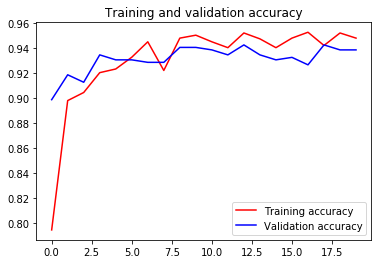

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

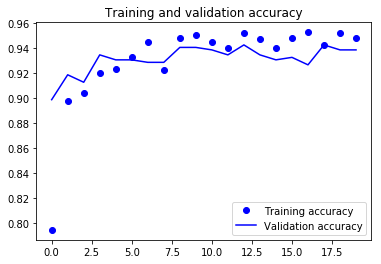

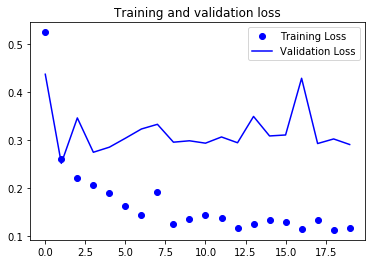

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

In [0]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes)
  if classes[0]>0.5:
    print(fn + " is a notmonkey")
  else:
    print(fn + " is a monkey")

Saving monkey.19.jpg to monkey.19.jpg
[[0.06089609]]
monkey.19.jpg is a monkey


In [0]:
!ls 

 gdrive		      monkey.35.jpg		  notmonkey.24.jpg.jpg
'monkey.20 (1).jpg'  'monkey.36 (1).jpg'	 'notmonkey.25.jpg (1).jpg'
'monkey.20 (2).jpg'   monkey.36.jpg		 'notmonkey.25.jpg (2).jpg'
'monkey.20 (3).jpg'  'monkey.45 (1).jpg'	 'notmonkey.25.jpg (3).jpg'
 monkey.20.jpg	      monkey.45.jpg		  notmonkey.25.jpg.jpg
'monkey.23 (1).jpg'  'monkey.46 (1).jpg'	  notmonkey.3.jpg
'monkey.23 (2).jpg'   monkey.46.jpg		  notmonkey.4.jpg
'monkey.23 (3).jpg'   monkey_detection.html	 'notmonkey.5 (1).jpg'
 monkey.23.jpg	      notmonkey.14.jpg		 'notmonkey.5 (2).jpg'
 monkey.34.jpg	     'notmonkey.24.jpg (1).jpg'   notmonkey.5.jpg
'monkey.35 (1).jpg'  'notmonkey.24.jpg (2).jpg'   sample_data


In [0]:
!ls /content/gdrive/'My Drive'/

Crowd_data_of_monkey	  training_data
monkey_classificatio.zip  validation_datset


In [0]:
!pip install h5py pyyaml
!pip install tf_nightly

In [0]:
model.save('./content')

In [0]:
ls

 content             'monkey.35 (1).jpg'         'notmonkey.24.jpg (2).jpg'
 gdrive/              monkey.35.jpg               notmonkey.24.jpg.jpg
 monkey.19.jpg       'monkey.36 (1).jpg'         'notmonkey.25.jpg (1).jpg'
'monkey.20 (1).jpg'   monkey.36.jpg              'notmonkey.25.jpg (2).jpg'
'monkey.20 (2).jpg'  'monkey.45 (1).jpg'         'notmonkey.25.jpg (3).jpg'
'monkey.20 (3).jpg'   monkey.45.jpg               notmonkey.25.jpg.jpg
 monkey.20.jpg       'monkey.46 (1).jpg'          notmonkey.3.jpg
'monkey.23 (1).jpg'   monkey.46.jpg               notmonkey.4.jpg
'monkey.23 (2).jpg'   monkey_detection.html      'notmonkey.5 (1).jpg'
'monkey.23 (3).jpg'   my_model.h5                'notmonkey.5 (2).jpg'
 monkey.23.jpg        notmonkey.14.jpg            notmonkey.5.jpg
 monkey.34.jpg       'notmonkey.24.jpg (1).jpg'   sample_data/


In [0]:
! cp('content/my_model.h5' ,'content/gdrive/My Drive')

/bin/bash: -c: line 0: syntax error near unexpected token `'content/my_model.h5''
/bin/bash: -c: line 0: ` cp('content/my_model.h5' ,'content/gdrive/My Drive')'


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

     |████████████████████████████████| 993kB 9.2MB/s 


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                       
drive = GoogleDrive(gauth)

In [0]:
model.save('model.h5')
model_file = drive.CreateFile({'title' : 'model.h5'})                       
model_file.SetContentFile('model.h5')                       
model_file.Upload()

In [0]:
drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '1ittyXfkj6lGAHOeaxP2vEwQ1z6o8oIZ8'})

In [0]:
! cd content

/bin/bash: line 0: cd: content: Not a directory


In [0]:
ls


 adc.json             monkey.34.jpg              'notmonkey.24.jpg (2).jpg'
 content             'monkey.35 (1).jpg'          notmonkey.24.jpg.jpg
 gdrive/              monkey.35.jpg              'notmonkey.25.jpg (1).jpg'
 model.h5            'monkey.36 (1).jpg'         'notmonkey.25.jpg (2).jpg'
 monkey.19.jpg        monkey.36.jpg              'notmonkey.25.jpg (3).jpg'
'monkey.20 (1).jpg'  'monkey.45 (1).jpg'          notmonkey.25.jpg.jpg
'monkey.20 (2).jpg'   monkey.45.jpg               notmonkey.3.jpg
'monkey.20 (3).jpg'  'monkey.46 (1).jpg'          notmonkey.4.jpg
 monkey.20.jpg        monkey.46.jpg              'notmonkey.5 (1).jpg'
'monkey.23 (1).jpg'   monkey_detection.html      'notmonkey.5 (2).jpg'
'monkey.23 (2).jpg'   my_model.h5                 notmonkey.5.jpg
'monkey.23 (3).jpg'   notmonkey.14.jpg            sample_data/
 monkey.23.jpg       'notmonkey.24.jpg (1).jpg'


In [0]:
!cd gdrive/

In [0]:
ls


 adc.json             monkey.34.jpg              'notmonkey.24.jpg (2).jpg'
 content             'monkey.35 (1).jpg'          notmonkey.24.jpg.jpg
 gdrive/              monkey.35.jpg              'notmonkey.25.jpg (1).jpg'
 model.h5            'monkey.36 (1).jpg'         'notmonkey.25.jpg (2).jpg'
 monkey.19.jpg        monkey.36.jpg              'notmonkey.25.jpg (3).jpg'
'monkey.20 (1).jpg'  'monkey.45 (1).jpg'          notmonkey.25.jpg.jpg
'monkey.20 (2).jpg'   monkey.45.jpg               notmonkey.3.jpg
'monkey.20 (3).jpg'  'monkey.46 (1).jpg'          notmonkey.4.jpg
 monkey.20.jpg        monkey.46.jpg              'notmonkey.5 (1).jpg'
'monkey.23 (1).jpg'   monkey_detection.html      'notmonkey.5 (2).jpg'
'monkey.23 (2).jpg'   my_model.h5                 notmonkey.5.jpg
'monkey.23 (3).jpg'   notmonkey.14.jpg            sample_data/
 monkey.23.jpg       'notmonkey.24.jpg (1).jpg'


In [0]:
newfile = drive.ListFile()

In [0]:
newfile

GoogleDriveFileList({})

In [0]:
newfile.GetList()

[GoogleDriveFile({'kind': 'drive#file', 'id': '1ittyXfkj6lGAHOeaxP2vEwQ1z6o8oIZ8', 'etag': '"Pu5D-rrLQ1obLibLazOjcgPU6jw/MTU1ODYwMzUxMTQ2Mg"', 'selfLink': 'https://www.googleapis.com/drive/v2/files/1ittyXfkj6lGAHOeaxP2vEwQ1z6o8oIZ8', 'webContentLink': 'https://drive.google.com/a/iiitu.ac.in/uc?id=1ittyXfkj6lGAHOeaxP2vEwQ1z6o8oIZ8&export=download', 'alternateLink': 'https://drive.google.com/a/iiitu.ac.in/file/d/1ittyXfkj6lGAHOeaxP2vEwQ1z6o8oIZ8/view?usp=drivesdk', 'embedLink': 'https://drive.google.com/a/iiitu.ac.in/file/d/1ittyXfkj6lGAHOeaxP2vEwQ1z6o8oIZ8/preview?usp=drivesdk', 'iconLink': 'https://drive-thirdparty.googleusercontent.com/16/type/application/octet-stream', 'title': 'transfer_learning.h5', 'mimeType': 'application/octet-stream', 'labels': {'starred': False, 'hidden': False, 'trashed': False, 'restricted': False, 'viewed': True}, 'copyRequiresWriterPermission': False, 'createdDate': '2019-05-23T09:23:35.365Z', 'modifiedDate': '2019-05-23T09:25:11.462Z', 'modifiedByMeDate':

In [0]:
    model_save_name = 'transfer.h5'
    path = F"/content/gdrive/My Drive/{model_save_name}"
    model.save(path)

In [0]:
import tensorflow as tf 
from keras.models import load_model
classifierLoad = tf.keras.models.load_model('my_model.h5')

In [0]:
classifierLoad.evaluate_generator()

TypeError: ignored

In [0]:
model